In [1]:
%matplotlib inline

In [2]:
import pytest
from spatialdata import SpatialData
from spatialdata._core.models import Image2DModel, Labels2DModel, ShapesModel
from spatialdata._core.transformations import Identity, Scale, Translation, MapAxis, Sequence, Affine
import scipy.misc
from skimage.segmentation import slic
import matplotlib.pyplot as plt
import numpy as np
from napari_spatialdata import Interactive
from pprint import pprint
import math
import pytest
import tempfile
import os
from spatialdata._core._spatialdata_ops import (
    get_transformation,
    set_transformation,
    remove_transformation,
    get_transformation_between_coordinate_systems,
)

SKIP_PLOTS = False

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
/Users/macbook/embl/projects/basel/spatialdata/spatialdata/_compat.py:18: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  warnings.warn(
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/experimental/pytorch/_annloader.py:18: UserWarning: Сould not load pytorch.
  warnings.warn("Сould not load pytorch.")


In [3]:
def hacky_plot(sdata) -> None:
    if SKIP_PLOTS:
        return
    print("plotting... ", end="")
    interactive = Interactive(sdata, headless=True)
    # to distinguish between the black of the image background and the black of the napari background (now white)
    interactive._viewer.theme = "light"
    screenshot = interactive._viewer.screenshot(canvas_only=True)
    interactive._viewer.theme = "dark"
    interactive._viewer.close()
    plt.imshow(screenshot)
    plt.show()
    print("done")

(768, 1024, 3)


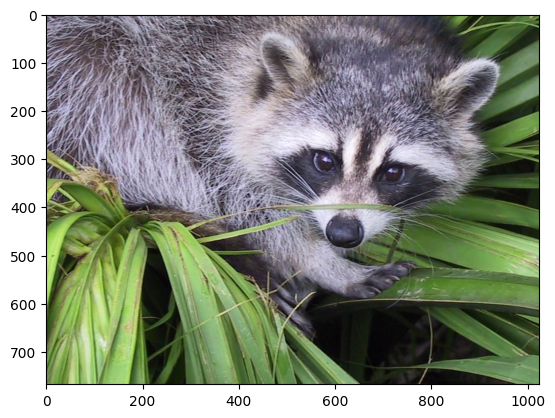

In [4]:
im_data = scipy.misc.face()
print(im_data.shape)
if not SKIP_PLOTS:
    plt.imshow(im_data)
    plt.show()

INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           


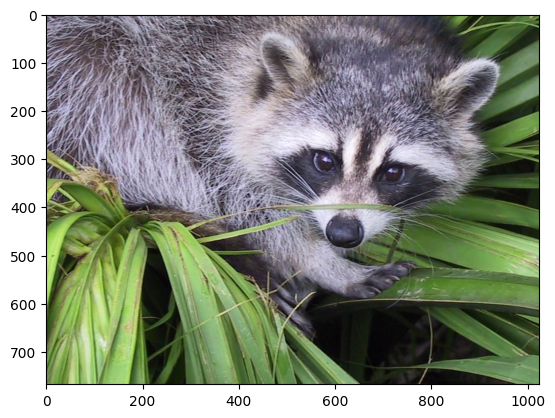

In [5]:
im = Image2DModel.parse(im_data, dims=["y", "x", "c"])
if not SKIP_PLOTS:
    plt.imshow(im.transpose("y", "x", "c").data)
    plt.show()

(768, 1024)


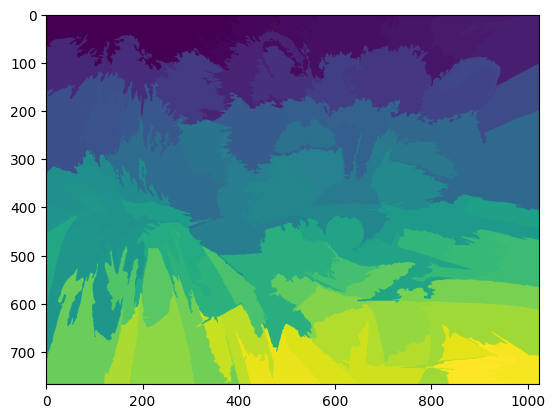

In [6]:
la_data = slic(im_data, n_segments=100, compactness=10, sigma=1)
print(la_data.shape)
if not SKIP_PLOTS:
    plt.imshow(la_data)
    plt.show()

In [7]:
la = Labels2DModel.parse(la_data, dims=["y", "x"])

INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('y', 'x').                                


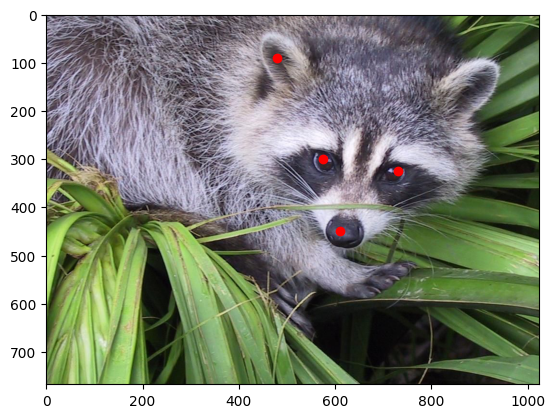

In [8]:
coords = np.array([[610, 450], [730, 325], [575, 300], [480, 90]])
if not SKIP_PLOTS:
    plt.imshow(im_data)
    plt.scatter(coords[:, 0], coords[:, 1], c="r")
    plt.show()

In [9]:
circles = ShapesModel.parse(coords=coords, shape_type="Circle", shape_size=np.array([30, 30, 30, 100]))

INFO     No index provided, using default index `np.arange(coords.shape[0])`.                                      


In [10]:
sdata0 = SpatialData(images={"face": im}, labels={"slic": la}, shapes={"landmarks": circles})
print(sdata0)

SpatialData object with:
├── Images
│     └── 'face': SpatialImage[cyx] (3, 768, 1024)
├── Labels
│     └── 'slic': SpatialImage[yx] (768, 1024)
└── Shapes
      └── 'landmarks': AnnData with `.osbm['spatial']` (4, 2)
with coordinate systems:
▸ global
    with elements: /images/face, /labels/slic, /shapes/landmarks



plotting... 

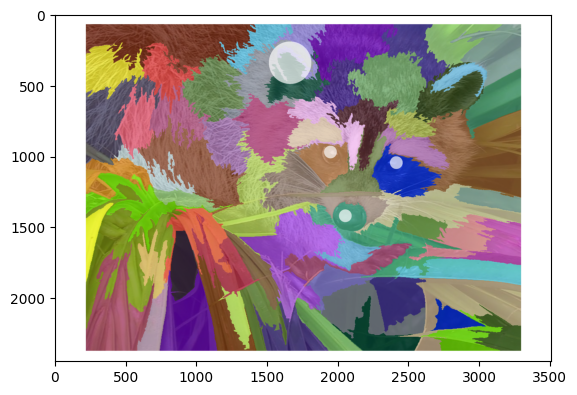

done


In [11]:
hacky_plot(sdata0)

In [12]:
pprint(get_transformation(im, get_all=True))
pprint(sdata0.coordinate_systems)

{'global': Identity }
['global']


In [13]:
set_transformation(im, Identity(), "my_other_space0")
set_transformation(la, Identity(), "my_other_space1")
print(get_transformation(im, get_all=True))
print(sdata0.coordinate_systems)

{'global': Identity , 'my_other_space0': Identity }
['my_other_space0', 'global', 'my_other_space1']


In [14]:
print(get_transformation(im))
print(get_transformation(im, to_coordinate_system="global"))
print(get_transformation(im, to_coordinate_system="my_other_space0"))

Identity 
Identity 
Identity 


plotting... 

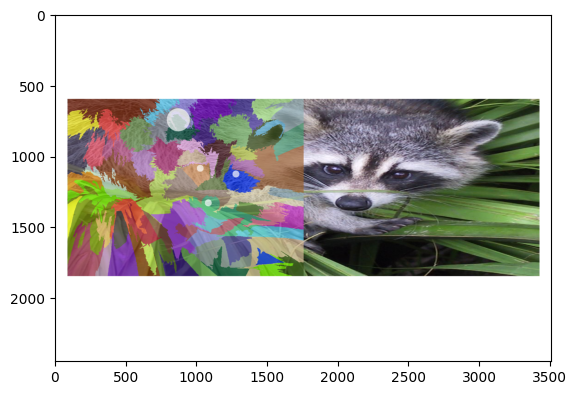

done


In [15]:
scale = Scale([2.0], axes=("x",))
set_transformation(im, scale)
hacky_plot(sdata0)

plotting... 

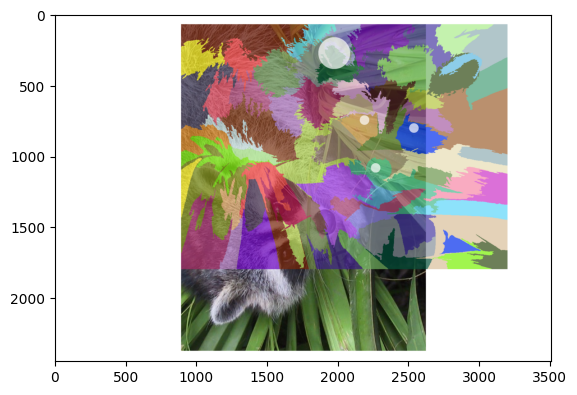

done


In [16]:
map_axis = MapAxis({"x": "y", "y": "x"})
set_transformation(im, map_axis)
hacky_plot(sdata0)

plotting... 

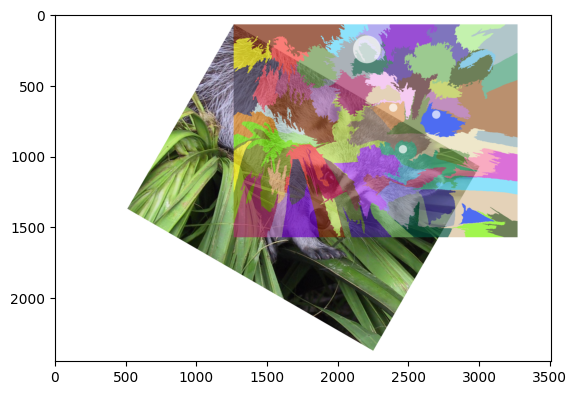

done


In [17]:
theta = math.pi / 6
rotation = Affine(
    [[math.cos(theta), -math.sin(theta), 0], [math.sin(theta), math.cos(theta), 0], [0, 0, 1]],
    input_axes=("x", "y"),
    output_axes=("x", "y"),
)
set_transformation(im, rotation)
hacky_plot(sdata0)

In [18]:
# translation will have effect only on the x, y axes since the z axis is not present in the image
translation = Translation([100, 200, 300], axes=("x", "y", "z"))
# the sequence can compose transformations even when the axes don't match
sequence = Sequence([rotation, rotation.inverse(), scale, scale.inverse(), translation])
print(sequence.to_affine_matrix(input_axes=("x", "y"), output_axes=("x", "y")))

[[1.00000000e+00 0.00000000e+00 1.00000000e+02]
 [5.55111512e-17 1.00000000e+00 2.00000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


plotting... 

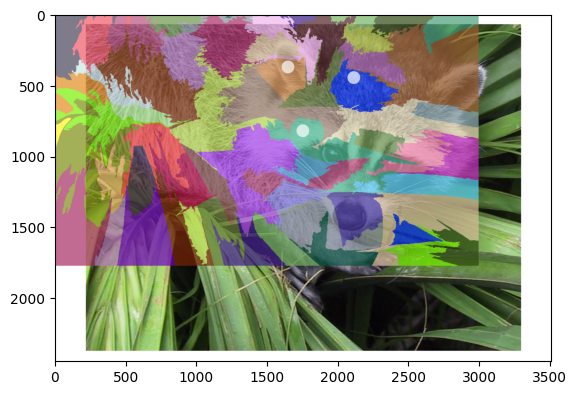

done


In [19]:
set_transformation(im, sequence)
hacky_plot(sdata0)

In [20]:
print(translation.to_affine_matrix(input_axes=("x", "y"), output_axes=("x", "y")))
print(translation.to_affine_matrix(input_axes=("x", "y", "z"), output_axes=("x", "y", "z")))
with pytest.raises(ValueError, match="Input axes must be a subset of output axes."):
    print(translation.to_affine_matrix(input_axes=("c", "z", "y", "x"), output_axes=("x", "y")))
# notice that z doesn't appear in the output axes since it was not in the input axes, but c is passed through since it was in the input axes
# you can see it below (this is the same matrix that gets printed as output
#     x   y   c
# c   0   0   1   0
# z   0   0   0   0
# y   0   1   0 100
# x   1   0   0 100
#     0   0   0   1
print(translation.to_affine_matrix(input_axes=("x", "y", "c"), output_axes=("c", "z", "y", "x")))

[[  1.   0. 100.]
 [  0.   1. 200.]
 [  0.   0.   1.]]
[[  1.   0.   0. 100.]
 [  0.   1.   0. 200.]
 [  0.   0.   1. 300.]
 [  0.   0.   0.   1.]]
[[  0.   0.   1.   0.]
 [  0.   0.   0.   0.]
 [  0.   1.   0. 200.]
 [  1.   0.   0. 100.]
 [  0.   0.   0.   1.]]


In [21]:
set_transformation(im, rotation)
print(get_transformation_between_coordinate_systems(sdata0, im, "global"))
print(get_transformation_between_coordinate_systems(sdata0, "global", im))

Sequence 
    Affine (x, y -> x, y)
        [ 0.8660254 -0.5        0.       ]
        [0.5       0.8660254 0.       ]
        [0. 0. 1.]
Sequence 
    Affine (x, y -> x, y)
        [0.8660254 0.5       0.       ]
        [-0.5        0.8660254  0.       ]
        [0. 0. 1.]


In [22]:
print(get_transformation_between_coordinate_systems(sdata0, im, "my_other_space0"))

Sequence 
    Identity 


In [23]:
print(get_transformation_between_coordinate_systems(sdata0, "global", "my_other_space0"))

Sequence 
    Affine (x, y -> x, y)
        [0.8660254 0.5       0.       ]
        [-0.5        0.8660254  0.       ]
        [0. 0. 1.]
    Identity 


In [24]:
print(get_transformation_between_coordinate_systems(sdata0, im, la))

Sequence 
    Affine (x, y -> x, y)
        [ 0.8660254 -0.5        0.       ]
        [0.5       0.8660254 0.       ]
        [0. 0. 1.]
    Identity 


In [25]:
print(get_transformation(im, get_all=True))
# remove_transformation_in_memory() is a static function, whle remove_transformation() can only operate on
# SpatialData objects, so it needs to check if the spatiadata object is backed by a zarr file
print(remove_transformation(im, "my_other_space0"))
print(get_transformation(im, get_all=True))

{'global': Affine (x, y -> x, y)
    [ 0.8660254 -0.5        0.       ]
    [0.5       0.8660254 0.       ]
    [0. 0. 1.], 'my_other_space0': Identity }
None
{'global': Affine (x, y -> x, y)
    [ 0.8660254 -0.5        0.       ]
    [0.5       0.8660254 0.       ]
    [0. 0. 1.]}


In [26]:
sdata1 = SpatialData(images={"im0": im, "im1": im, "im2": im})
with pytest.raises(ValueError, match="Element found multiple times in the SpatialData object"):
    set_transformation(im, Identity(), write_to_sdata=sdata1)

In [27]:
print(get_transformation(im, get_all=True))
remove_transformation(im, "global")
print(get_transformation(im, get_all=True))

{'global': Affine (x, y -> x, y)
    [ 0.8660254 -0.5        0.       ]
    [0.5       0.8660254 0.       ]
    [0. 0. 1.]}
{}


In [28]:
tmpdir = tempfile.TemporaryDirectory()

In [29]:
zarr_path = os.path.join(tmpdir.name, "sdata.zarr")
# writing an object re-reads the file immediately...
sdata1.write(zarr_path)
print(sdata1)
# ...so now the objects we read are distinct
im0 = sdata1.images["im0"]
im1 = sdata1.images["im1"]
im2 = sdata1.images["im2"]
assert len(set([id(im0), id(im1), id(im2)])) == 3

SpatialData object with:
└── Images
      ├── 'im0': SpatialImage[cyx] (3, 768, 1024)
      ├── 'im1': SpatialImage[cyx] (3, 768, 1024)
      └── 'im2': SpatialImage[cyx] (3, 768, 1024)
with coordinate systems:



In [30]:
scale = Scale([2.0], axes=("x",))
set_transformation(im0, scale, "space0")
set_transformation(im1, scale.inverse(), "space0")
set_transformation(im1, scale, "space1")
set_transformation(im2, scale.inverse(), "space1")
set_transformation(im2, scale, "space2")

print(sdata1.coordinate_systems)
print(
    get_transformation_between_coordinate_systems(
        sdata=sdata1, source_coordinate_system="space0", target_coordinate_system="space2"
    ).to_affine_matrix(input_axes=("x", "y"), output_axes=("x", "y"))
)
print(
    get_transformation_between_coordinate_systems(
        sdata=sdata1, source_coordinate_system="space2", target_coordinate_system="space0"
    ).to_affine_matrix(input_axes=("x"), output_axes=("x"))
)

['space1', 'space0', 'space2']
[[16.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
[[0.0625 0.    ]
 [0.     1.    ]]


In [31]:
tmpdir.cleanup()

INFO     No transformations found in the element, adding a default identity transformation to the coordinate system
         global                                                                                                    
plotting... 

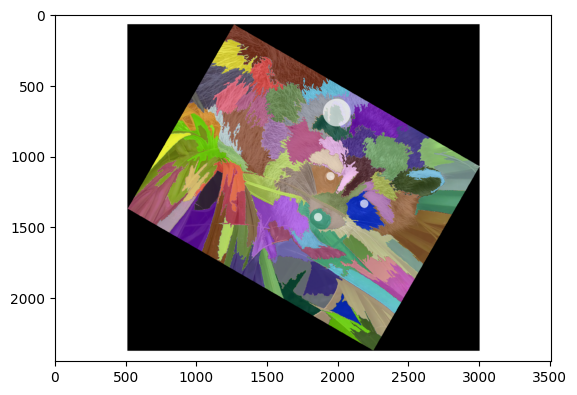

done
INFO     No transformations found in the element, adding a default identity transformation to the coordinate system
         global                                                                                                    
plotting... 

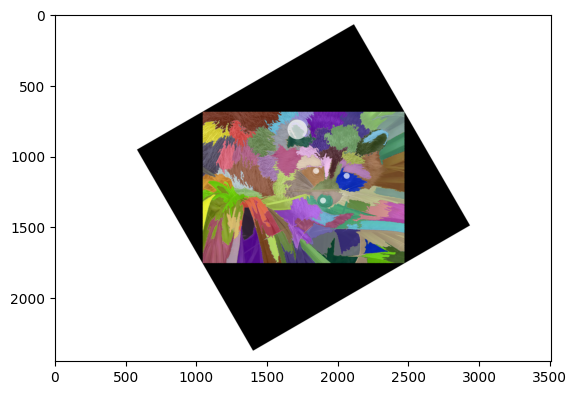

done
plotting... 

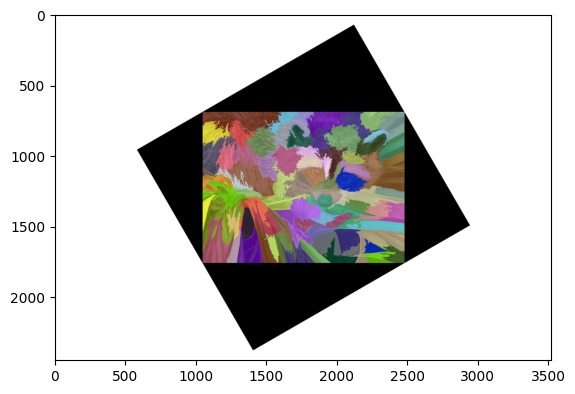

done


In [32]:
# I stop here regarding the transformations, there are some bugs (forgot to finish one part the code), gonna fix it
# see how the points are wrong
# see also how the new image is now rotated (the data is rotated itself)! the padding has been added by the method
rotated_sdata = rotation.transform(sdata0)
hacky_plot(rotated_sdata)

rotated_sdata = rotation.transform(sdata0, maintain_positioning=True)
hacky_plot(rotated_sdata)

merged_sdata = SpatialData(images={"face_rotated": rotated_sdata.images["face"]}, labels={"slic": la})
hacky_plot(merged_sdata)

In [33]:
# just a little more on io and backing
tmpdir = tempfile.TemporaryDirectory()

In [34]:
zarr_path = os.path.join(tmpdir.name, "sdata.zarr")
sdata0.write(zarr_path)

with pytest.raises(ValueError, match="Can't overwrite the original file"):
    sdata0.write(zarr_path)

another_zarr_path = os.path.join(tmpdir.name, "another_sdata.zarr")
sdata0.write(another_zarr_path)

with pytest.raises(ValueError, match="The Zarr store already exists. Use overwrite=True to overwrite the store."):
    sdata0.write(zarr_path)

sdata0.write(zarr_path, overwrite=True)

no parent found for <ome_zarr.reader.Label object at 0x7f81621589a0>: None


INFO     The Zarr file used for backing will now change from /tmp/tmp0ngjb4mf/sdata.zarr to                        
         /tmp/tmp0ngjb4mf/another_sdata.zarr                                                                       


no parent found for <ome_zarr.reader.Label object at 0x7f81a6c67640>: None


INFO     The Zarr file used for backing will now change from /tmp/tmp0ngjb4mf/another_sdata.zarr to                
         /tmp/tmp0ngjb4mf/sdata.zarr                                                                               
INFO     The Zarr file used for backing will now change from /tmp/tmp0ngjb4mf/another_sdata.zarr to                
         /tmp/tmp0ngjb4mf/sdata.zarr                                                                               


no parent found for <ome_zarr.reader.Label object at 0x7f8190c3e7d0>: None


In [35]:
sdata2 = SpatialData(images=sdata0.images)

# notice how sdata2 is not bakced, but the element is backed from zarr from the old sdata object, this is fine, let's see why
print(sdata2.is_backed())
print(sdata2.images["face"].data)

# the function called without the argument "write_to_sdata" does not overwrite the transformation of the original
# file, it jsut modifies the in-memory object of sdata2
set_transformation(sdata2.images["face"], scale)

# let's check this
print(get_transformation(sdata0.images["face"], get_all=True))
print(get_transformation(sdata2.images["face"], get_all=True))

# but
sdata0_read_again = SpatialData.read(zarr_path)
get_transformation(sdata0_read_again.images["face"], get_all=True)
# correct!

False
dask.array<from-zarr, shape=(3, 768, 1024), dtype=uint8, chunksize=(3, 768, 1024), chunktype=numpy.ndarray>
{'global': Scale (x)
    [2.]}
{'global': Scale (x)
    [2.]}


{}

In [36]:
# if we want to modify the transformation of sdata2 to disk, we have first to save it
yet_another_zarr_path = os.path.join(tmpdir.name, "yet_another_sdata.zarr")
# but now that we save it the image will point to the new zarr store; it has nothing to do with the original one anymore
sdata2.write(yet_another_zarr_path)
print(sdata2.images["face"].data)

# this modifies the transformation in-memory
set_transformation(sdata2.images["face"], scale)
# while this will change it on disk
set_transformation(sdata2.images["face"], scale, write_to_sdata=sdata2)

dask.array<from-zarr, shape=(3, 768, 1024), dtype=uint8, chunksize=(3, 768, 1024), chunktype=numpy.ndarray>


In [37]:
# finally notice that we can add new elements to a spatialdata object after it has been created
# if the object is not backed, the data will be added in-memory, otherwise it will be also immediately saved to disk
print(sdata2.is_backed())
face0 = sdata2.images["face"]
sdata2.add_image("another_face", face0)
face1 = sdata2.images["another_face"]
assert id(face0) != id(face1)
# notice how the objects are different, because when we call add_image(), the new image is immediately re-read from disk

True


In [38]:
# let's show the behaviour in-memory: let's trick the object to believe that is in-memory
sdata2.path = None
sdata2.add_image("yet_another_face", face0)
face2 = sdata2.images["yet_another_face"]
assert id(face0) == id(face2)

In [39]:
tmpdir.cleanup()